In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
from dataset import load_image

In [4]:
import torch

In [5]:
from utils import variable

In [6]:
from generate_masks import get_model

In [7]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [8]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [10]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from unet_models import unet11

# model_path = 'data/models/unet16_binary_20/model_0.pt'
model_path = '../TernausNet/TernausNet.pt'
# model = get_model(model_path, model_type='UNet11', problem_type='binary') # errors with this!

# this is for the carvana/building model
# model =  unet11(pretrained='carvana')
# state = torch.load(model_path)
# model.load_state_dict(state['model'])

# start from only vgg
model = unet11(pretrained=True)

# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [11]:
# import the helper functions
from test_unet_helpers import *

import rasterio
import glob
import os,sys
#from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
import numpy as np
#from scipy import misc
import fiona
# import geopandas as gpd
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

In [12]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0.tif' # desktop
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop
# gt_image_2 = '../rasters/union_impervious_raster_2_0_0.tif' # laptop
#gt_image_2 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0.tif'

# specify images for 0.5 meter analysis
gt_image_05 = '../../rasters/union_impervious_raster_0_5.tif' # desktop
# gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # laptop
#gt_image_05 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif'

# specify the shapefile
# shpfile = '../Denver_Sample_Sites/union/union_grid_index256.shp'
shpfile = '../../union/union.shp' # desktop
# shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
#     for s in shp:
#         # rows.append(shape(s['geometry']))
#         pass
        
        
    shp_bounds = shp.bounds

In [13]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [14]:
os.path.exists(gt_image_2)

True

In [15]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

generating sample 1 of 10000
generating sample 2 of 10000
generating sample 3 of 10000
generating sample 4 of 10000
generating sample 5 of 10000
generating sample 6 of 10000
generating sample 7 of 10000
generating sample 8 of 10000
generating sample 9 of 10000
generating sample 10 of 10000
generating sample 11 of 10000
generating sample 12 of 10000
generating sample 13 of 10000
generating sample 14 of 10000
generating sample 15 of 10000
generating sample 16 of 10000
generating sample 17 of 10000
generating sample 18 of 10000
generating sample 19 of 10000
generating sample 20 of 10000
generating sample 21 of 10000
generating sample 22 of 10000
generating sample 23 of 10000
generating sample 24 of 10000
generating sample 25 of 10000
generating sample 26 of 10000
generating sample 27 of 10000
generating sample 28 of 10000
generating sample 29 of 10000
generating sample 30 of 10000
generating sample 31 of 10000
generating sample 32 of 10000
generating sample 33 of 10000
generating sample 3

generating sample 277 of 10000
generating sample 278 of 10000
generating sample 279 of 10000
generating sample 280 of 10000
generating sample 281 of 10000
generating sample 282 of 10000
generating sample 283 of 10000
generating sample 284 of 10000
generating sample 285 of 10000
generating sample 286 of 10000
generating sample 287 of 10000
generating sample 288 of 10000
generating sample 289 of 10000
generating sample 290 of 10000
generating sample 291 of 10000
generating sample 292 of 10000
generating sample 293 of 10000
generating sample 294 of 10000
generating sample 295 of 10000
generating sample 296 of 10000
generating sample 297 of 10000
generating sample 298 of 10000
generating sample 299 of 10000
generating sample 300 of 10000
generating sample 301 of 10000
generating sample 302 of 10000
generating sample 303 of 10000
generating sample 304 of 10000
generating sample 305 of 10000
generating sample 306 of 10000
generating sample 307 of 10000
generating sample 308 of 10000
generati

generating sample 556 of 10000
generating sample 557 of 10000
generating sample 558 of 10000
generating sample 559 of 10000
generating sample 560 of 10000
generating sample 561 of 10000
generating sample 562 of 10000
generating sample 563 of 10000
generating sample 564 of 10000
generating sample 565 of 10000
generating sample 566 of 10000
generating sample 567 of 10000
generating sample 568 of 10000
generating sample 569 of 10000
generating sample 570 of 10000
generating sample 571 of 10000
generating sample 572 of 10000
generating sample 573 of 10000
generating sample 574 of 10000
generating sample 575 of 10000
generating sample 576 of 10000
generating sample 577 of 10000
generating sample 578 of 10000
generating sample 579 of 10000
generating sample 580 of 10000
generating sample 581 of 10000
generating sample 582 of 10000
generating sample 583 of 10000
generating sample 584 of 10000
generating sample 585 of 10000
generating sample 586 of 10000
generating sample 587 of 10000
generati

generating sample 829 of 10000
generating sample 830 of 10000
generating sample 831 of 10000
generating sample 832 of 10000
generating sample 833 of 10000
generating sample 834 of 10000
generating sample 835 of 10000
generating sample 836 of 10000
generating sample 837 of 10000
generating sample 838 of 10000
generating sample 839 of 10000
generating sample 840 of 10000
generating sample 841 of 10000
generating sample 842 of 10000
generating sample 843 of 10000
generating sample 844 of 10000
generating sample 845 of 10000
generating sample 846 of 10000
generating sample 847 of 10000
generating sample 848 of 10000
generating sample 849 of 10000
generating sample 850 of 10000
generating sample 851 of 10000
generating sample 852 of 10000
generating sample 853 of 10000
generating sample 854 of 10000
generating sample 855 of 10000
generating sample 856 of 10000
generating sample 857 of 10000
generating sample 858 of 10000
generating sample 859 of 10000
generating sample 860 of 10000
generati

generating sample 1096 of 10000
generating sample 1097 of 10000
generating sample 1098 of 10000
generating sample 1099 of 10000
generating sample 1100 of 10000
generating sample 1101 of 10000
generating sample 1102 of 10000
generating sample 1103 of 10000
generating sample 1104 of 10000
generating sample 1105 of 10000
generating sample 1106 of 10000
generating sample 1107 of 10000
generating sample 1108 of 10000
generating sample 1109 of 10000
generating sample 1110 of 10000
generating sample 1111 of 10000
generating sample 1112 of 10000
generating sample 1113 of 10000
generating sample 1114 of 10000
generating sample 1115 of 10000
generating sample 1116 of 10000
generating sample 1117 of 10000
generating sample 1118 of 10000
generating sample 1119 of 10000
generating sample 1120 of 10000
generating sample 1121 of 10000
generating sample 1122 of 10000
generating sample 1123 of 10000
generating sample 1124 of 10000
generating sample 1125 of 10000
generating sample 1126 of 10000
generati

generating sample 1381 of 10000
generating sample 1382 of 10000
generating sample 1383 of 10000
generating sample 1384 of 10000
generating sample 1385 of 10000
generating sample 1386 of 10000
generating sample 1387 of 10000
generating sample 1388 of 10000
generating sample 1389 of 10000
generating sample 1390 of 10000
generating sample 1391 of 10000
generating sample 1392 of 10000
generating sample 1393 of 10000
generating sample 1394 of 10000
generating sample 1395 of 10000
generating sample 1396 of 10000
generating sample 1397 of 10000
generating sample 1398 of 10000
generating sample 1399 of 10000
generating sample 1400 of 10000
generating sample 1401 of 10000
generating sample 1402 of 10000
generating sample 1403 of 10000
generating sample 1404 of 10000
generating sample 1405 of 10000
generating sample 1406 of 10000
generating sample 1407 of 10000
generating sample 1408 of 10000
generating sample 1409 of 10000
generating sample 1410 of 10000
generating sample 1411 of 10000
generati

generating sample 1654 of 10000
generating sample 1655 of 10000
generating sample 1656 of 10000
generating sample 1657 of 10000
generating sample 1658 of 10000
generating sample 1659 of 10000
generating sample 1660 of 10000
generating sample 1661 of 10000
generating sample 1662 of 10000
generating sample 1663 of 10000
generating sample 1664 of 10000
generating sample 1665 of 10000
generating sample 1666 of 10000
generating sample 1667 of 10000
generating sample 1668 of 10000
generating sample 1669 of 10000
generating sample 1670 of 10000
generating sample 1671 of 10000
generating sample 1672 of 10000
generating sample 1673 of 10000
generating sample 1674 of 10000
generating sample 1675 of 10000
generating sample 1676 of 10000
generating sample 1677 of 10000
generating sample 1678 of 10000
generating sample 1679 of 10000
generating sample 1680 of 10000
generating sample 1681 of 10000
generating sample 1682 of 10000
generating sample 1683 of 10000
generating sample 1684 of 10000
generati

generating sample 1930 of 10000
generating sample 1931 of 10000
generating sample 1932 of 10000
generating sample 1933 of 10000
generating sample 1934 of 10000
generating sample 1935 of 10000
generating sample 1936 of 10000
generating sample 1937 of 10000
generating sample 1938 of 10000
generating sample 1939 of 10000
generating sample 1940 of 10000
generating sample 1941 of 10000
generating sample 1942 of 10000
generating sample 1943 of 10000
generating sample 1944 of 10000
generating sample 1945 of 10000
generating sample 1946 of 10000
generating sample 1947 of 10000
generating sample 1948 of 10000
generating sample 1949 of 10000
generating sample 1950 of 10000
generating sample 1951 of 10000
generating sample 1952 of 10000
generating sample 1953 of 10000
generating sample 1954 of 10000
generating sample 1955 of 10000
generating sample 1956 of 10000
generating sample 1957 of 10000
generating sample 1958 of 10000
generating sample 1959 of 10000
generating sample 1960 of 10000
generati

generating sample 2204 of 10000
generating sample 2205 of 10000
generating sample 2206 of 10000
generating sample 2207 of 10000
generating sample 2208 of 10000
generating sample 2209 of 10000
generating sample 2210 of 10000
generating sample 2211 of 10000
generating sample 2212 of 10000
generating sample 2213 of 10000
generating sample 2214 of 10000
generating sample 2215 of 10000
generating sample 2216 of 10000
generating sample 2217 of 10000
generating sample 2218 of 10000
generating sample 2219 of 10000
generating sample 2220 of 10000
generating sample 2221 of 10000
generating sample 2222 of 10000
generating sample 2223 of 10000
generating sample 2224 of 10000
generating sample 2225 of 10000
generating sample 2226 of 10000
generating sample 2227 of 10000
generating sample 2228 of 10000
generating sample 2229 of 10000
generating sample 2230 of 10000
generating sample 2231 of 10000
generating sample 2232 of 10000
generating sample 2233 of 10000
generating sample 2234 of 10000
generati

generating sample 2477 of 10000
generating sample 2478 of 10000
generating sample 2479 of 10000
generating sample 2480 of 10000
generating sample 2481 of 10000
generating sample 2482 of 10000
generating sample 2483 of 10000
generating sample 2484 of 10000
generating sample 2485 of 10000
generating sample 2486 of 10000
generating sample 2487 of 10000
generating sample 2488 of 10000
generating sample 2489 of 10000
generating sample 2490 of 10000
generating sample 2491 of 10000
generating sample 2492 of 10000
generating sample 2493 of 10000
generating sample 2494 of 10000
generating sample 2495 of 10000
generating sample 2496 of 10000
generating sample 2497 of 10000
generating sample 2498 of 10000
generating sample 2499 of 10000
generating sample 2500 of 10000
generating sample 2501 of 10000
generating sample 2502 of 10000
generating sample 2503 of 10000
generating sample 2504 of 10000
generating sample 2505 of 10000
generating sample 2506 of 10000
generating sample 2507 of 10000
generati

generating sample 2740 of 10000
generating sample 2741 of 10000
generating sample 2742 of 10000
generating sample 2743 of 10000
generating sample 2744 of 10000
generating sample 2745 of 10000
generating sample 2746 of 10000
generating sample 2747 of 10000
generating sample 2748 of 10000
generating sample 2749 of 10000
generating sample 2750 of 10000
generating sample 2751 of 10000
generating sample 2752 of 10000
generating sample 2753 of 10000
generating sample 2754 of 10000
generating sample 2755 of 10000
generating sample 2756 of 10000
generating sample 2757 of 10000
generating sample 2758 of 10000
generating sample 2759 of 10000
generating sample 2760 of 10000
generating sample 2761 of 10000
generating sample 2762 of 10000
generating sample 2763 of 10000
generating sample 2764 of 10000
generating sample 2765 of 10000
generating sample 2766 of 10000
generating sample 2767 of 10000
generating sample 2768 of 10000
generating sample 2769 of 10000
generating sample 2770 of 10000
generati

generating sample 3016 of 10000
generating sample 3017 of 10000
generating sample 3018 of 10000
generating sample 3019 of 10000
generating sample 3020 of 10000
generating sample 3021 of 10000
generating sample 3022 of 10000
generating sample 3023 of 10000
generating sample 3024 of 10000
generating sample 3025 of 10000
generating sample 3026 of 10000
generating sample 3027 of 10000
generating sample 3028 of 10000
generating sample 3029 of 10000
generating sample 3030 of 10000
generating sample 3031 of 10000
generating sample 3032 of 10000
generating sample 3033 of 10000
generating sample 3034 of 10000
generating sample 3035 of 10000
generating sample 3036 of 10000
generating sample 3037 of 10000
generating sample 3038 of 10000
generating sample 3039 of 10000
generating sample 3040 of 10000
generating sample 3041 of 10000
generating sample 3042 of 10000
generating sample 3043 of 10000
generating sample 3044 of 10000
generating sample 3045 of 10000
generating sample 3046 of 10000
generati

generating sample 3273 of 10000
generating sample 3274 of 10000
generating sample 3275 of 10000
generating sample 3276 of 10000
generating sample 3277 of 10000
generating sample 3278 of 10000
generating sample 3279 of 10000
generating sample 3280 of 10000
generating sample 3281 of 10000
generating sample 3282 of 10000
generating sample 3283 of 10000
generating sample 3284 of 10000
generating sample 3285 of 10000
generating sample 3286 of 10000
generating sample 3287 of 10000
generating sample 3288 of 10000
generating sample 3289 of 10000
generating sample 3290 of 10000
generating sample 3291 of 10000
generating sample 3292 of 10000
generating sample 3293 of 10000
generating sample 3294 of 10000
generating sample 3295 of 10000
generating sample 3296 of 10000
generating sample 3297 of 10000
generating sample 3298 of 10000
generating sample 3299 of 10000
generating sample 3300 of 10000
generating sample 3301 of 10000
generating sample 3302 of 10000
generating sample 3303 of 10000
generati

generating sample 3537 of 10000
generating sample 3538 of 10000
generating sample 3539 of 10000
generating sample 3540 of 10000
generating sample 3541 of 10000
generating sample 3542 of 10000
generating sample 3543 of 10000
generating sample 3544 of 10000
generating sample 3545 of 10000
generating sample 3546 of 10000
generating sample 3547 of 10000
generating sample 3548 of 10000
generating sample 3549 of 10000
generating sample 3550 of 10000
generating sample 3551 of 10000
generating sample 3552 of 10000
generating sample 3553 of 10000
generating sample 3554 of 10000
generating sample 3555 of 10000
generating sample 3556 of 10000
generating sample 3557 of 10000
generating sample 3558 of 10000
generating sample 3559 of 10000
generating sample 3560 of 10000
generating sample 3561 of 10000
generating sample 3562 of 10000
generating sample 3563 of 10000
generating sample 3564 of 10000
generating sample 3565 of 10000
generating sample 3566 of 10000
generating sample 3567 of 10000
generati

generating sample 3812 of 10000
generating sample 3813 of 10000
generating sample 3814 of 10000
generating sample 3815 of 10000
generating sample 3816 of 10000
generating sample 3817 of 10000
generating sample 3818 of 10000
generating sample 3819 of 10000
generating sample 3820 of 10000
generating sample 3821 of 10000
generating sample 3822 of 10000
generating sample 3823 of 10000
generating sample 3824 of 10000
generating sample 3825 of 10000
generating sample 3826 of 10000
generating sample 3827 of 10000
generating sample 3828 of 10000
generating sample 3829 of 10000
generating sample 3830 of 10000
generating sample 3831 of 10000
generating sample 3832 of 10000
generating sample 3833 of 10000
generating sample 3834 of 10000
generating sample 3835 of 10000
generating sample 3836 of 10000
generating sample 3837 of 10000
generating sample 3838 of 10000
generating sample 3839 of 10000
generating sample 3840 of 10000
generating sample 3841 of 10000
generating sample 3842 of 10000
generati

generating sample 4091 of 10000
generating sample 4092 of 10000
generating sample 4093 of 10000
generating sample 4094 of 10000
generating sample 4095 of 10000
generating sample 4096 of 10000
generating sample 4097 of 10000
generating sample 4098 of 10000
generating sample 4099 of 10000
generating sample 4100 of 10000
generating sample 4101 of 10000
generating sample 4102 of 10000
generating sample 4103 of 10000
generating sample 4104 of 10000
generating sample 4105 of 10000
generating sample 4106 of 10000
generating sample 4107 of 10000
generating sample 4108 of 10000
generating sample 4109 of 10000
generating sample 4110 of 10000
generating sample 4111 of 10000
generating sample 4112 of 10000
generating sample 4113 of 10000
generating sample 4114 of 10000
generating sample 4115 of 10000
generating sample 4116 of 10000
generating sample 4117 of 10000
generating sample 4118 of 10000
generating sample 4119 of 10000
generating sample 4120 of 10000
generating sample 4121 of 10000
generati

generating sample 4360 of 10000
generating sample 4361 of 10000
generating sample 4362 of 10000
generating sample 4363 of 10000
generating sample 4364 of 10000
generating sample 4365 of 10000
generating sample 4366 of 10000
generating sample 4367 of 10000
generating sample 4368 of 10000
generating sample 4369 of 10000
generating sample 4370 of 10000
generating sample 4371 of 10000
generating sample 4372 of 10000
generating sample 4373 of 10000
generating sample 4374 of 10000
generating sample 4375 of 10000
generating sample 4376 of 10000
generating sample 4377 of 10000
generating sample 4378 of 10000
generating sample 4379 of 10000
generating sample 4380 of 10000
generating sample 4381 of 10000
generating sample 4382 of 10000
generating sample 4383 of 10000
generating sample 4384 of 10000
generating sample 4385 of 10000
generating sample 4386 of 10000
generating sample 4387 of 10000
generating sample 4388 of 10000
generating sample 4389 of 10000
generating sample 4390 of 10000
generati

generating sample 4632 of 10000
generating sample 4633 of 10000
generating sample 4634 of 10000
generating sample 4635 of 10000
generating sample 4636 of 10000
generating sample 4637 of 10000
generating sample 4638 of 10000
generating sample 4639 of 10000
generating sample 4640 of 10000
generating sample 4641 of 10000
generating sample 4642 of 10000
generating sample 4643 of 10000
generating sample 4644 of 10000
generating sample 4645 of 10000
generating sample 4646 of 10000
generating sample 4647 of 10000
generating sample 4648 of 10000
generating sample 4649 of 10000
generating sample 4650 of 10000
generating sample 4651 of 10000
generating sample 4652 of 10000
generating sample 4653 of 10000
generating sample 4654 of 10000
generating sample 4655 of 10000
generating sample 4656 of 10000
generating sample 4657 of 10000
generating sample 4658 of 10000
generating sample 4659 of 10000
generating sample 4660 of 10000
generating sample 4661 of 10000
generating sample 4662 of 10000
generati

generating sample 4919 of 10000
generating sample 4920 of 10000
generating sample 4921 of 10000
generating sample 4922 of 10000
generating sample 4923 of 10000
generating sample 4924 of 10000
generating sample 4925 of 10000
generating sample 4926 of 10000
generating sample 4927 of 10000
generating sample 4928 of 10000
generating sample 4929 of 10000
generating sample 4930 of 10000
generating sample 4931 of 10000
generating sample 4932 of 10000
generating sample 4933 of 10000
generating sample 4934 of 10000
generating sample 4935 of 10000
generating sample 4936 of 10000
generating sample 4937 of 10000
generating sample 4938 of 10000
generating sample 4939 of 10000
generating sample 4940 of 10000
generating sample 4941 of 10000
generating sample 4942 of 10000
generating sample 4943 of 10000
generating sample 4944 of 10000
generating sample 4945 of 10000
generating sample 4946 of 10000
generating sample 4947 of 10000
generating sample 4948 of 10000
generating sample 4949 of 10000
generati

generating sample 5179 of 10000
generating sample 5180 of 10000
generating sample 5181 of 10000
generating sample 5182 of 10000
generating sample 5183 of 10000
generating sample 5184 of 10000
generating sample 5185 of 10000
generating sample 5186 of 10000
generating sample 5187 of 10000
generating sample 5188 of 10000
generating sample 5189 of 10000
generating sample 5190 of 10000
generating sample 5191 of 10000
generating sample 5192 of 10000
generating sample 5193 of 10000
generating sample 5194 of 10000
generating sample 5195 of 10000
generating sample 5196 of 10000
generating sample 5197 of 10000
generating sample 5198 of 10000
generating sample 5199 of 10000
generating sample 5200 of 10000
generating sample 5201 of 10000
generating sample 5202 of 10000
generating sample 5203 of 10000
generating sample 5204 of 10000
generating sample 5205 of 10000
generating sample 5206 of 10000
generating sample 5207 of 10000
generating sample 5208 of 10000
generating sample 5209 of 10000
generati

generating sample 5463 of 10000
generating sample 5464 of 10000
generating sample 5465 of 10000
generating sample 5466 of 10000
generating sample 5467 of 10000
generating sample 5468 of 10000
generating sample 5469 of 10000
generating sample 5470 of 10000
generating sample 5471 of 10000
generating sample 5472 of 10000
generating sample 5473 of 10000
generating sample 5474 of 10000
generating sample 5475 of 10000
generating sample 5476 of 10000
generating sample 5477 of 10000
generating sample 5478 of 10000
generating sample 5479 of 10000
generating sample 5480 of 10000
generating sample 5481 of 10000
generating sample 5482 of 10000
generating sample 5483 of 10000
generating sample 5484 of 10000
generating sample 5485 of 10000
generating sample 5486 of 10000
generating sample 5487 of 10000
generating sample 5488 of 10000
generating sample 5489 of 10000
generating sample 5490 of 10000
generating sample 5491 of 10000
generating sample 5492 of 10000
generating sample 5493 of 10000
generati

generating sample 5743 of 10000
generating sample 5744 of 10000
generating sample 5745 of 10000
generating sample 5746 of 10000
generating sample 5747 of 10000
generating sample 5748 of 10000
generating sample 5749 of 10000
generating sample 5750 of 10000
generating sample 5751 of 10000
generating sample 5752 of 10000
generating sample 5753 of 10000
generating sample 5754 of 10000
generating sample 5755 of 10000
generating sample 5756 of 10000
generating sample 5757 of 10000
generating sample 5758 of 10000
generating sample 5759 of 10000
generating sample 5760 of 10000
generating sample 5761 of 10000
generating sample 5762 of 10000
generating sample 5763 of 10000
generating sample 5764 of 10000
generating sample 5765 of 10000
generating sample 5766 of 10000
generating sample 5767 of 10000
generating sample 5768 of 10000
generating sample 5769 of 10000
generating sample 5770 of 10000
generating sample 5771 of 10000
generating sample 5772 of 10000
generating sample 5773 of 10000
generati

generating sample 6020 of 10000
generating sample 6021 of 10000
generating sample 6022 of 10000
generating sample 6023 of 10000
generating sample 6024 of 10000
generating sample 6025 of 10000
generating sample 6026 of 10000
generating sample 6027 of 10000
generating sample 6028 of 10000
generating sample 6029 of 10000
generating sample 6030 of 10000
generating sample 6031 of 10000
generating sample 6032 of 10000
generating sample 6033 of 10000
generating sample 6034 of 10000
generating sample 6035 of 10000
generating sample 6036 of 10000
generating sample 6037 of 10000
generating sample 6038 of 10000
generating sample 6039 of 10000
generating sample 6040 of 10000
generating sample 6041 of 10000
generating sample 6042 of 10000
generating sample 6043 of 10000
generating sample 6044 of 10000
generating sample 6045 of 10000
generating sample 6046 of 10000
generating sample 6047 of 10000
generating sample 6048 of 10000
generating sample 6049 of 10000
generating sample 6050 of 10000
generati

generating sample 6306 of 10000
generating sample 6307 of 10000
generating sample 6308 of 10000
generating sample 6309 of 10000
generating sample 6310 of 10000
generating sample 6311 of 10000
generating sample 6312 of 10000
generating sample 6313 of 10000
generating sample 6314 of 10000
generating sample 6315 of 10000
generating sample 6316 of 10000
generating sample 6317 of 10000
generating sample 6318 of 10000
generating sample 6319 of 10000
generating sample 6320 of 10000
generating sample 6321 of 10000
generating sample 6322 of 10000
generating sample 6323 of 10000
generating sample 6324 of 10000
generating sample 6325 of 10000
generating sample 6326 of 10000
generating sample 6327 of 10000
generating sample 6328 of 10000
generating sample 6329 of 10000
generating sample 6330 of 10000
generating sample 6331 of 10000
generating sample 6332 of 10000
generating sample 6333 of 10000
generating sample 6334 of 10000
generating sample 6335 of 10000
generating sample 6336 of 10000
generati

generating sample 6586 of 10000
generating sample 6587 of 10000
generating sample 6588 of 10000
generating sample 6589 of 10000
generating sample 6590 of 10000
generating sample 6591 of 10000
generating sample 6592 of 10000
generating sample 6593 of 10000
generating sample 6594 of 10000
generating sample 6595 of 10000
generating sample 6596 of 10000
generating sample 6597 of 10000
generating sample 6598 of 10000
generating sample 6599 of 10000
generating sample 6600 of 10000
generating sample 6601 of 10000
generating sample 6602 of 10000
generating sample 6603 of 10000
generating sample 6604 of 10000
generating sample 6605 of 10000
generating sample 6606 of 10000
generating sample 6607 of 10000
generating sample 6608 of 10000
generating sample 6609 of 10000
generating sample 6610 of 10000
generating sample 6611 of 10000
generating sample 6612 of 10000
generating sample 6613 of 10000
generating sample 6614 of 10000
generating sample 6615 of 10000
generating sample 6616 of 10000
generati

generating sample 6850 of 10000
generating sample 6851 of 10000
generating sample 6852 of 10000
generating sample 6853 of 10000
generating sample 6854 of 10000
generating sample 6855 of 10000
generating sample 6856 of 10000
generating sample 6857 of 10000
generating sample 6858 of 10000
generating sample 6859 of 10000
generating sample 6860 of 10000
generating sample 6861 of 10000
generating sample 6862 of 10000
generating sample 6863 of 10000
generating sample 6864 of 10000
generating sample 6865 of 10000
generating sample 6866 of 10000
generating sample 6867 of 10000
generating sample 6868 of 10000
generating sample 6869 of 10000
generating sample 6870 of 10000
generating sample 6871 of 10000
generating sample 6872 of 10000
generating sample 6873 of 10000
generating sample 6874 of 10000
generating sample 6875 of 10000
generating sample 6876 of 10000
generating sample 6877 of 10000
generating sample 6878 of 10000
generating sample 6879 of 10000
generating sample 6880 of 10000
generati

generating sample 7121 of 10000
generating sample 7122 of 10000
generating sample 7123 of 10000
generating sample 7124 of 10000
generating sample 7125 of 10000
generating sample 7126 of 10000
generating sample 7127 of 10000
generating sample 7128 of 10000
generating sample 7129 of 10000
generating sample 7130 of 10000
generating sample 7131 of 10000
generating sample 7132 of 10000
generating sample 7133 of 10000
generating sample 7134 of 10000
generating sample 7135 of 10000
generating sample 7136 of 10000
generating sample 7137 of 10000
generating sample 7138 of 10000
generating sample 7139 of 10000
generating sample 7140 of 10000
generating sample 7141 of 10000
generating sample 7142 of 10000
generating sample 7143 of 10000
generating sample 7144 of 10000
generating sample 7145 of 10000
generating sample 7146 of 10000
generating sample 7147 of 10000
generating sample 7148 of 10000
generating sample 7149 of 10000
generating sample 7150 of 10000
generating sample 7151 of 10000
generati

generating sample 7408 of 10000
generating sample 7409 of 10000
generating sample 7410 of 10000
generating sample 7411 of 10000
generating sample 7412 of 10000
generating sample 7413 of 10000
generating sample 7414 of 10000
generating sample 7415 of 10000
generating sample 7416 of 10000
generating sample 7417 of 10000
generating sample 7418 of 10000
generating sample 7419 of 10000
generating sample 7420 of 10000
generating sample 7421 of 10000
generating sample 7422 of 10000
generating sample 7423 of 10000
generating sample 7424 of 10000
generating sample 7425 of 10000
generating sample 7426 of 10000
generating sample 7427 of 10000
generating sample 7428 of 10000
generating sample 7429 of 10000
generating sample 7430 of 10000
generating sample 7431 of 10000
generating sample 7432 of 10000
generating sample 7433 of 10000
generating sample 7434 of 10000
generating sample 7435 of 10000
generating sample 7436 of 10000
generating sample 7437 of 10000
generating sample 7438 of 10000
generati

generating sample 7672 of 10000
generating sample 7673 of 10000
generating sample 7674 of 10000
generating sample 7675 of 10000
generating sample 7676 of 10000
generating sample 7677 of 10000
generating sample 7678 of 10000
generating sample 7679 of 10000
generating sample 7680 of 10000
generating sample 7681 of 10000
generating sample 7682 of 10000
generating sample 7683 of 10000
generating sample 7684 of 10000
generating sample 7685 of 10000
generating sample 7686 of 10000
generating sample 7687 of 10000
generating sample 7688 of 10000
generating sample 7689 of 10000
generating sample 7690 of 10000
generating sample 7691 of 10000
generating sample 7692 of 10000
generating sample 7693 of 10000
generating sample 7694 of 10000
generating sample 7695 of 10000
generating sample 7696 of 10000
generating sample 7697 of 10000
generating sample 7698 of 10000
generating sample 7699 of 10000
generating sample 7700 of 10000
generating sample 7701 of 10000
generating sample 7702 of 10000
generati

generating sample 7934 of 10000
generating sample 7935 of 10000
generating sample 7936 of 10000
generating sample 7937 of 10000
generating sample 7938 of 10000
generating sample 7939 of 10000
generating sample 7940 of 10000
generating sample 7941 of 10000
generating sample 7942 of 10000
generating sample 7943 of 10000
generating sample 7944 of 10000
generating sample 7945 of 10000
generating sample 7946 of 10000
generating sample 7947 of 10000
generating sample 7948 of 10000
generating sample 7949 of 10000
generating sample 7950 of 10000
generating sample 7951 of 10000
generating sample 7952 of 10000
generating sample 7953 of 10000
generating sample 7954 of 10000
generating sample 7955 of 10000
generating sample 7956 of 10000
generating sample 7957 of 10000
generating sample 7958 of 10000
generating sample 7959 of 10000
generating sample 7960 of 10000
generating sample 7961 of 10000
generating sample 7962 of 10000
generating sample 7963 of 10000
generating sample 7964 of 10000
generati

generating sample 8191 of 10000
generating sample 8192 of 10000
generating sample 8193 of 10000
generating sample 8194 of 10000
generating sample 8195 of 10000
generating sample 8196 of 10000
generating sample 8197 of 10000
generating sample 8198 of 10000
generating sample 8199 of 10000
generating sample 8200 of 10000
generating sample 8201 of 10000
generating sample 8202 of 10000
generating sample 8203 of 10000
generating sample 8204 of 10000
generating sample 8205 of 10000
generating sample 8206 of 10000
generating sample 8207 of 10000
generating sample 8208 of 10000
generating sample 8209 of 10000
generating sample 8210 of 10000
generating sample 8211 of 10000
generating sample 8212 of 10000
generating sample 8213 of 10000
generating sample 8214 of 10000
generating sample 8215 of 10000
generating sample 8216 of 10000
generating sample 8217 of 10000
generating sample 8218 of 10000
generating sample 8219 of 10000
generating sample 8220 of 10000
generating sample 8221 of 10000
generati

generating sample 8451 of 10000
generating sample 8452 of 10000
generating sample 8453 of 10000
generating sample 8454 of 10000
generating sample 8455 of 10000
generating sample 8456 of 10000
generating sample 8457 of 10000
generating sample 8458 of 10000
generating sample 8459 of 10000
generating sample 8460 of 10000
generating sample 8461 of 10000
generating sample 8462 of 10000
generating sample 8463 of 10000
generating sample 8464 of 10000
generating sample 8465 of 10000
generating sample 8466 of 10000
generating sample 8467 of 10000
generating sample 8468 of 10000
generating sample 8469 of 10000
generating sample 8470 of 10000
generating sample 8471 of 10000
generating sample 8472 of 10000
generating sample 8473 of 10000
generating sample 8474 of 10000
generating sample 8475 of 10000
generating sample 8476 of 10000
generating sample 8477 of 10000
generating sample 8478 of 10000
generating sample 8479 of 10000
generating sample 8480 of 10000
generating sample 8481 of 10000
generati

generating sample 8712 of 10000
generating sample 8713 of 10000
generating sample 8714 of 10000
generating sample 8715 of 10000
generating sample 8716 of 10000
generating sample 8717 of 10000
generating sample 8718 of 10000
generating sample 8719 of 10000
generating sample 8720 of 10000
generating sample 8721 of 10000
generating sample 8722 of 10000
generating sample 8723 of 10000
generating sample 8724 of 10000
generating sample 8725 of 10000
generating sample 8726 of 10000
generating sample 8727 of 10000
generating sample 8728 of 10000
generating sample 8729 of 10000
generating sample 8730 of 10000
generating sample 8731 of 10000
generating sample 8732 of 10000
generating sample 8733 of 10000
generating sample 8734 of 10000
generating sample 8735 of 10000
generating sample 8736 of 10000
generating sample 8737 of 10000
generating sample 8738 of 10000
generating sample 8739 of 10000
generating sample 8740 of 10000
generating sample 8741 of 10000
generating sample 8742 of 10000
generati

generating sample 8970 of 10000
generating sample 8971 of 10000
generating sample 8972 of 10000
generating sample 8973 of 10000
generating sample 8974 of 10000
generating sample 8975 of 10000
generating sample 8976 of 10000
generating sample 8977 of 10000
generating sample 8978 of 10000
generating sample 8979 of 10000
generating sample 8980 of 10000
generating sample 8981 of 10000
generating sample 8982 of 10000
generating sample 8983 of 10000
generating sample 8984 of 10000
generating sample 8985 of 10000
generating sample 8986 of 10000
generating sample 8987 of 10000
generating sample 8988 of 10000
generating sample 8989 of 10000
generating sample 8990 of 10000
generating sample 8991 of 10000
generating sample 8992 of 10000
generating sample 8993 of 10000
generating sample 8994 of 10000
generating sample 8995 of 10000
generating sample 8996 of 10000
generating sample 8997 of 10000
generating sample 8998 of 10000
generating sample 8999 of 10000
generating sample 9000 of 10000
generati

generating sample 9258 of 10000
generating sample 9259 of 10000
generating sample 9260 of 10000
generating sample 9261 of 10000
generating sample 9262 of 10000
generating sample 9263 of 10000
generating sample 9264 of 10000
generating sample 9265 of 10000
generating sample 9266 of 10000
generating sample 9267 of 10000
generating sample 9268 of 10000
generating sample 9269 of 10000
generating sample 9270 of 10000
generating sample 9271 of 10000
generating sample 9272 of 10000
generating sample 9273 of 10000
generating sample 9274 of 10000
generating sample 9275 of 10000
generating sample 9276 of 10000
generating sample 9277 of 10000
generating sample 9278 of 10000
generating sample 9279 of 10000
generating sample 9280 of 10000
generating sample 9281 of 10000
generating sample 9282 of 10000
generating sample 9283 of 10000
generating sample 9284 of 10000
generating sample 9285 of 10000
generating sample 9286 of 10000
generating sample 9287 of 10000
generating sample 9288 of 10000
generati

generating sample 9518 of 10000
generating sample 9519 of 10000
generating sample 9520 of 10000
generating sample 9521 of 10000
generating sample 9522 of 10000
generating sample 9523 of 10000
generating sample 9524 of 10000
generating sample 9525 of 10000
generating sample 9526 of 10000
generating sample 9527 of 10000
generating sample 9528 of 10000
generating sample 9529 of 10000
generating sample 9530 of 10000
generating sample 9531 of 10000
generating sample 9532 of 10000
generating sample 9533 of 10000
generating sample 9534 of 10000
generating sample 9535 of 10000
generating sample 9536 of 10000
generating sample 9537 of 10000
generating sample 9538 of 10000
generating sample 9539 of 10000
generating sample 9540 of 10000
generating sample 9541 of 10000
generating sample 9542 of 10000
generating sample 9543 of 10000
generating sample 9544 of 10000
generating sample 9545 of 10000
generating sample 9546 of 10000
generating sample 9547 of 10000
generating sample 9548 of 10000
generati

generating sample 9780 of 10000
generating sample 9781 of 10000
generating sample 9782 of 10000
generating sample 9783 of 10000
generating sample 9784 of 10000
generating sample 9785 of 10000
generating sample 9786 of 10000
generating sample 9787 of 10000
generating sample 9788 of 10000
generating sample 9789 of 10000
generating sample 9790 of 10000
generating sample 9791 of 10000
generating sample 9792 of 10000
generating sample 9793 of 10000
generating sample 9794 of 10000
generating sample 9795 of 10000
generating sample 9796 of 10000
generating sample 9797 of 10000
generating sample 9798 of 10000
generating sample 9799 of 10000
generating sample 9800 of 10000
generating sample 9801 of 10000
generating sample 9802 of 10000
generating sample 9803 of 10000
generating sample 9804 of 10000
generating sample 9805 of 10000
generating sample 9806 of 10000
generating sample 9807 of 10000
generating sample 9808 of 10000
generating sample 9809 of 10000
generating sample 9810 of 10000
generati

In [16]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [17]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [18]:
# rand_inds = random.sample(range(num),10)

# for sample_ind in rand_inds:
#     print('\n\nSample ID: {}'.format(sample_ind))
#     # check the images
#     gt_2m_rowcol = [x[2:] for x in gt_pts_MS]
#     gt_dataset = gtDatasetSampler(gt_image_2, gt_2m_rowcol) # 64 pixel dimension windows
#     # gt_dataset = gtDatasetSampler(gt_image_2, gt_pts_PAN) # 64 pixel dimension windows
#     sample_gt = gt_dataset[sample_ind]
#     print(sample_gt.shape)
#     #plt.imshow(sample_gt)
#     #plt.colorbar()
#     #plt.show()

#     dg_dataset = DigitalGlobeSampler(img_2m, coords)
#     # dg_dataset = DigitalGlobeSampler(img_pan)
#     sample = np.rollaxis(dg_dataset[sample_ind],0,3)
#     print(sample.shape)
#     #plt.imshow(misc.bytescale(sample[:,:,[4,3,1]]))
#     #plt.show()
    
#     plt.imshow(misc.bytescale(sample[:,:,[4,3,1]]))
#     plt.imshow(sample_gt, alpha = 0.15)
#     plt.show()
    

#     # see that they are the same size


In [19]:
# img_file_name = 'data/cropped_train/instrument_dataset_3/images/frame004.jpg' # use GBDX
# gt_file_name = 'data/cropped_train/instrument_dataset_3/binary_masks/frame004.png' # use gt sampler

In [20]:
# # img = load_image(img_file_name)
# img = sample[:,:,[4,3,1]] # DG image

# # gt = cv2.imread(gt_file_name, 0) > 0
# gt = sample_gt

In [21]:
# get the average mean and standard deviation across the bands to apply to the transform
# dg_dataset = DigitalGlobeSampler(img_2m, coords)
# means, stds = [], []
# for i in range(num):
#     temp = np.rollaxis(dg_dataset[i],0,3)
#     temp2 = temp[:,:,[4,3,1]] #rgb
    
#     mean_a = list(temp2.mean(axis=(0,1)))
#     std_a = list(temp2.std(axis=(0,1)))
    
#     means.append(mean_a)
#     stds.append(std_a)
    


In [22]:
# np.array(means).shape, np.array(stds).shape
# np.array(means).mean(axis=0), np.array(stds).mean(axis=0)
    

In [23]:
img_transform = Compose([
    Normalize(mean=[1630.7322, 1574.9552, 1549.1031], std=[837.0847 , 766.4114 , 604.51605])
])

In [24]:
# input_img = torch.unsqueeze(variable(img_transform(a), volatile=True), dim=0)

In [25]:
# mask = model(input_img.cpu())
# mask.shape

In [26]:
# mask_array = mask.data[0].cpu().numpy()[0]

In [27]:
# imshow(mask_array)
# plt.colorbar()
# plt.show()

# imshow(misc.bytescale(img.compute()))
# plt.show()

In [28]:
# dg_dataset2 = DigitalGlobeSamplerTensor(img_2m, coords, transform=img_transform) # will return RGB by default
# dg_dataset2[0].shape, dg_dataset[1].shape

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [29]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [41]:
## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:100], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=10, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=10, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform) # will return RGB by default
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:100], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform)
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform)

dg_dl_train = DataLoader(dg_dataset_train, batch_size=10, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=10, shuffle=False)

In [31]:
gt_dataset_train[0], dg_dataset_train[0].shape

(
 (0 ,.,.) = 
    1   1   1  ...    0   0   0
    1   1   1  ...    0   0   0
    1   1   1  ...    0   0   0
      ...       ⋱       ...    
    0   1   1  ...    1   1   1
    0   0   0  ...    1   1   1
    0   0   0  ...    1   1   1
 [torch.FloatTensor of size 1x64x64], torch.Size([3, 64, 64]))

In [32]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = 10
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [145]:
import tqdm
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
    
def train(args, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=None, fold=None, num_classes=None):
    lr = args.lr
    #n_epochs = n_epochs or args.n_epochs
    n_epochs = n_epochs
    optimizer = init_optimizer(lr)

    root = Path(args.root)
    model_path = root / 'model_{fold}.pt'.format(fold=fold)
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

    report_each = 10
    log = root.joinpath('train_{fold}.log'.format(fold=fold)).open('at', encoding='utf8')
    valid_losses = []
    
    model=model.cuda()    
    
    # record some data
    mean_loss_list = []
    mean_losses = []
    val_loss_list = []
    #for epoch in range(epoch, n_epochs + 1):
    for epoch in range(1,5):
        print('on epoch {}'.format(epoch))
        
        model.train() #try moving above loop
        random.seed()
        #tq = tqdm.tqdm(total=(len(train_loader) * args.batch_size))
        tq = tqdm.tqdm(total=(8000))
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        tl = train_loader
        
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                #print('inputs shape: {}'.format(inputs.shape))
                #print('targets shape: {}'.format(targets.shape))
                inputs, targets = variable(inputs).cuda(), variable(targets).cuda()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.data[0])
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                
                #record losses
                mean_losses.append(mean_loss)
                
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
                    #pass
                
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            valid_metrics = validation(model, criterion, valid_loader, num_classes)
            write_event(log, step, **valid_metrics)
            valid_loss = valid_metrics['valid_loss']
            valid_losses.append(valid_loss)
            
            
            # record mean losses
            mean_loss_list.append(mean_losses)
            val_loss_list.append(valid_losses)
            
        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return
        
        
        except Exception as e:
            print(e)
        
    return mean_loss_list, val_loss_list
    
def train2(args, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=None, fold=None, num_classes=None):
    
    
    lr = args.lr
    #n_epochs = n_epochs or args.n_epochs
    n_epochs = n_epochs
    #optimizer = init_optimizer(lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # model on GPU
    model=model.cuda()    
    
    # record some data
    mean_loss_list = []
    mean_losses = []
    val_loss_list = []
    for epoch in [1,2]:
        print('on epoch {}'.format(epoch))
        
        #model.train() #try moving above loop
        #random.seed()
                
        mean_loss = 0.0
        running_loss = 0.0
        print('training...')
        
        tl = train_loader
        for i, (inputs, targets) in enumerate(tl):
            
            # get the inputs
            inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)                
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss
            print('[%d, %5d] loss: %.3f' %(epoch, i + 1, loss))
                    
        
        
    return inputs, targets

def train3(args, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=None, fold=None, num_classes=None):
    
    
    lr = args.lr
    #n_epochs = n_epochs or args.n_epochs
    n_epochs = n_epochs
    #optimizer = init_optimizer(lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # model on GPU
    model=model.cuda()    
    
    # record some data
    mean_loss_list = []
    mean_losses = []
    val_loss_list = []
    
    
    # try manually going through 2 epochs

    #model.train() #try moving above loop
    #random.seed()

    mean_loss = 0.0
    running_loss = 0.0
    print('training...')

    epoch = 1
    tl = train_loader
    for i, (inputs, targets) in enumerate(tl):

        # get the inputs
        inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)                
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss
        print('[%d, %5d] loss: %.3f' %(epoch, i + 1, loss))
        
    print('manually on epoch 2')
    epoch=2
    tl = train_loader
    for i, (inputs, targets) in enumerate(tl):

        # get the inputs
        inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)                
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss
        print('[%d, %5d] loss: %.3f' %(epoch, i + 1, loss))

        
        
    return inputs, targets

In [135]:

print('gt shape: {}'.format(gt_dataset_train[0].shape))
print(dg_dataset_train[0].shape)

gt shape: torch.Size([1, 64, 64])
torch.Size([3, 64, 64])


In [136]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

In [146]:
# set a model from scratch
model = unet11(pretrained=False)
in_,out_ = train2(
        init_optimizer=lambda lr: Adam(model.parameters(), lr=lr),
        args=args,
        model=model,
        criterion=loss,
        train_loader=zip(dg_dl_train, gt_dl_train),
        valid_loader=zip(dg_dl_val, gt_dl_val),
        validation=valid,
        fold=args.fold,
        num_classes=num_classes,
        n_epochs=6
    )

in_.shape, out_.shape

on epoch 1
training...
[1,     1] loss: 1.697
[1,     2] loss: 1.474
[1,     3] loss: 1.499
[1,     4] loss: 1.563
[1,     5] loss: 1.537
[1,     6] loss: 1.525
[1,     7] loss: 1.653
[1,     8] loss: 1.789
[1,     9] loss: 1.405
[1,    10] loss: 1.540
on epoch 2
training...


(torch.Size([10, 3, 64, 64]), torch.Size([10, 1, 64, 64]))

In [142]:
### call outside training method, no loop

model = unet11(pretrained=False).cuda()
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)

mean_loss = 0.0
running_loss = 0.0
print('training...')

epoch = 1
tl = zip(dg_dl_train, gt_dl_train)
for i, (inputs, targets) in enumerate(tl):

    # get the inputs
    inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

    # zero parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    i_loss = criterion(outputs, targets)                
    i_loss.backward()
    optimizer.step()

    # print statistics
    running_loss += i_loss
    print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

print('manually on epoch 2')
epoch=2
tl = zip(dg_dl_train, gt_dl_train)
for i, (inputs, targets) in enumerate(tl):

    # get the inputs
    inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

    # zero parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    i_loss = criterion(outputs, targets)                
    i_loss.backward()
    optimizer.step()

    # print statistics
    running_loss += i_loss
    print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

training...
[1,     1] loss: 1.771
[1,     2] loss: 1.595
[1,     3] loss: 1.610
[1,     4] loss: 1.660
[1,     5] loss: 1.636
[1,     6] loss: 1.630
[1,     7] loss: 1.726
[1,     8] loss: 1.834
[1,     9] loss: 1.525
[1,    10] loss: 1.629
manually on epoch 2
[2,     1] loss: 1.736
[2,     2] loss: 1.528
[2,     3] loss: 1.533
[2,     4] loss: 1.602
[2,     5] loss: 1.562
[2,     6] loss: 1.561
[2,     7] loss: 1.662
[2,     8] loss: 1.775
[2,     9] loss: 1.341
[2,    10] loss: 1.464


In [144]:
### call outside training method, in loop

model = unet11(pretrained=False).cuda()
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)

mean_loss = 0.0
running_loss = 0.0
print('training...')

#tl = zip(dg_dl_train, gt_dl_train)
for i in range(2):
    epoch = i+1
    print('on epoch {}'.format(epoch))
    tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
    for i, (inputs, targets) in enumerate(tl):

        # get the inputs
        inputs, targets = variable(inputs).cuda(), variable(targets).cuda()

        # zero parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        i_loss = criterion(outputs, targets)                
        i_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += i_loss
        print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))



training...
on epoch 1
[1,     1] loss: 1.719
[1,     2] loss: 1.508
[1,     3] loss: 1.526
[1,     4] loss: 1.590
[1,     5] loss: 1.563
[1,     6] loss: 1.558
[1,     7] loss: 1.672
[1,     8] loss: 1.794
[1,     9] loss: 1.430
[1,    10] loss: 1.557
on epoch 2
[2,     1] loss: 1.685
[2,     2] loss: 1.435
[2,     3] loss: 1.442
[2,     4] loss: 1.525
[2,     5] loss: 1.477
[2,     6] loss: 1.478
[2,     7] loss: 1.598
[2,     8] loss: 1.740
[2,     9] loss: 1.215
[2,    10] loss: 1.380


In [138]:
model.parameters

<bound method Module.parameters of UNet11(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

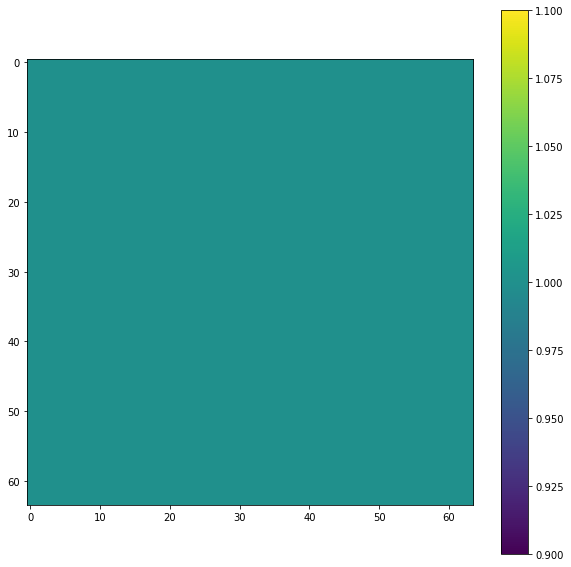

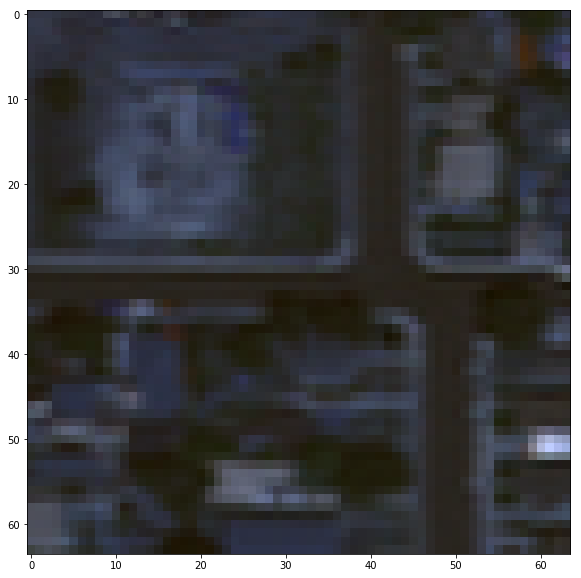

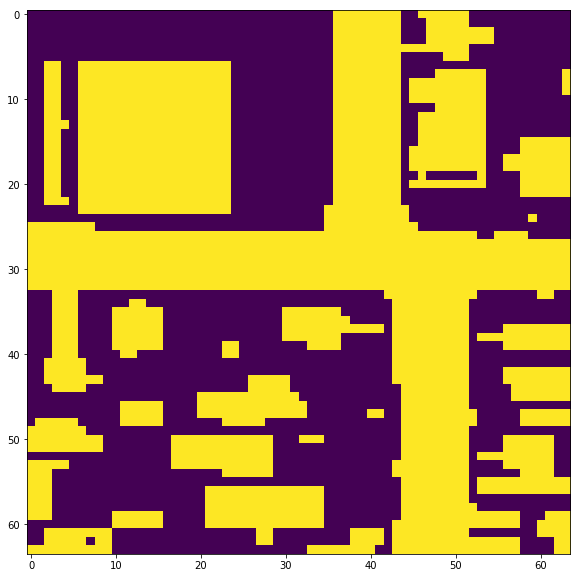

In [66]:
# check one of the test images
test_ind = 100
input_img = torch.unsqueeze(variable(dg_dataset_val[test_ind], volatile=True), dim=0) 
mask = model(input_img)


mask_im = mask.squeeze().data.cpu().numpy()
mask_binary = mask_im.copy()

thresh = 0
mask_binary[mask_im<=thresh] = 0
mask_binary[mask_im>thresh] = 1
plt.imshow(mask_binary)
plt.colorbar()
plt.show()

source_im = dg_dataset_val[test_ind].numpy()
plt.imshow(misc.bytescale(np.rollaxis(source_im, 0, 3)))
plt.show()

gt_im = gt_dataset_val[test_ind].numpy().squeeze()
plt.imshow(gt_im)
plt.show()

In [109]:
gt_im.shape

(1, 64, 64)